In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
#hyperparameters
lr = 2e-4  # could also use two lrs, one for gen and one for disc
batch_size = 128
image_size = 64  #The input is a 3x64x64 input image 
channels_img = 1 #number of channels in the output image (taking 3 will cause error)
noise_dim = 100
epochs = 5
disc_feature_size = 64 
gen_feature_size = 64
beta1 = 0.5
#the output is a 3x64x64 RGB image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [ ]:
transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
])
    


In [ ]:
mnist_train = dsets.MNIST(root = 'data/',
                      train=True,
                      transform = transform,
                      download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


3


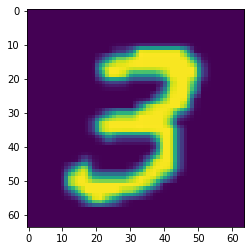

In [ ]:
#visulaising dataset
#mnist_train = [(img, label),(img, label),............]
plt.imshow(mnist_train[7][0].squeeze(0))
print(mnist_train[7][1])

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                      batch_size = batch_size,
                                      shuffle=True)

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
#converting noise to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64)
#assuming gen_feature_size=64


class Generator(nn.Module):
    def __init__(self,noise_dim,channels_img,gen_feature_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1)
            nn.ConvTranspose2d( noise_dim, gen_feature_size * 16, 4, 1, 0),  #gen_feature_size*16=1024 as shown in paper 
            nn.BatchNorm2d(gen_feature_size *16),
            nn.ReLU(True),
            # state size. (gen_feature_size *16) x 4 x 4
            nn.ConvTranspose2d(gen_feature_size *16, gen_feature_size *8, 4, 2, 1),
            nn.BatchNorm2d(gen_feature_size *8),
            nn.ReLU(True),
            # state size. (gen_feature_size *8) x 8 x 8
            nn.ConvTranspose2d( gen_feature_size *8, gen_feature_size *4, 4, 2, 1),
            nn.BatchNorm2d(gen_feature_size *4),
            nn.ReLU(True),
            # state size. (gen_feature_size *4) x 16 x 16
            nn.ConvTranspose2d( gen_feature_size *4, gen_feature_size *2, 4, 2, 1),
            nn.BatchNorm2d(gen_feature_size *2),
            nn.ReLU(True),
            # state size. (gen_feature_size *2) x 32 x 32
            nn.ConvTranspose2d( gen_feature_size *2, channels_img, 4, 2, 1),
            nn.Tanh()
            # state size. (channels_img) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# visualising the outputs from each layer in generator


netG = Generator(noise_dim,channels_img,gen_feature_size=64).to(device)
netG.apply(initialize_weights)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [ ]:
# Here, Discriminator takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, 
# and outputs the final probability through a Sigmoid activation function

class Discriminator(nn.Module):
    def __init__(self, channels_img,disc_feature_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (channels_img) x 64 x 64
            nn.Conv2d(channels_img, disc_feature_size, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_feature_size) x 32 x 32
            nn.Conv2d(disc_feature_size, disc_feature_size * 2, 4, 2, 1),
            nn.BatchNorm2d(disc_feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_feature_size*2) x 16 x 16
            nn.Conv2d(disc_feature_size * 2, disc_feature_size * 4, 4, 2, 1),
            nn.BatchNorm2d(disc_feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_feature_size*4) x 8 x 8
            nn.Conv2d(disc_feature_size * 4,disc_feature_size * 8, 4, 2, 1),
            nn.BatchNorm2d(disc_feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_feature_size*8) x 4 x 4
            nn.Conv2d(disc_feature_size * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# visualising the outputs from each layer in discriminator

netD = Discriminator(channels_img,disc_feature_size).to(device)
netD.apply(initialize_weights)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, noise_dim , 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader , 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.3982	Loss_G: 0.7703	D(x): 0.5035	D(G(z)): 0.5093 / 0.4629
[0/5][50/469]	Loss_D: 0.1016	Loss_G: 2.9286	D(x): 0.9564	D(G(z)): 0.0554 / 0.0535
[0/5][100/469]	Loss_D: 0.0301	Loss_G: 4.1173	D(x): 0.9876	D(G(z)): 0.0174 / 0.0167
[0/5][150/469]	Loss_D: 0.0820	Loss_G: 3.7829	D(x): 0.9604	D(G(z)): 0.0406 / 0.0237
[0/5][200/469]	Loss_D: 0.7824	Loss_G: 1.5449	D(x): 0.6904	D(G(z)): 0.3344 / 0.2160
[0/5][250/469]	Loss_D: 1.0197	Loss_G: 2.6330	D(x): 0.7648	D(G(z)): 0.5251 / 0.0724
[0/5][300/469]	Loss_D: 1.1821	Loss_G: 1.2633	D(x): 0.6975	D(G(z)): 0.5567 / 0.2850
[0/5][350/469]	Loss_D: 1.1891	Loss_G: 1.2028	D(x): 0.5469	D(G(z)): 0.4280 / 0.3119
[0/5][400/469]	Loss_D: 1.1277	Loss_G: 0.9807	D(x): 0.5086	D(G(z)): 0.3505 / 0.3839
[0/5][450/469]	Loss_D: 1.1261	Loss_G: 0.9677	D(x): 0.5623	D(G(z)): 0.4142 / 0.3852
[1/5][0/469]	Loss_D: 1.1030	Loss_G: 1.0217	D(x): 0.5773	D(G(z)): 0.4126 / 0.3681
[1/5][50/469]	Loss_D: 1.1862	Loss_G: 1.0401	D(x): 0.5841	D(G(z)): 

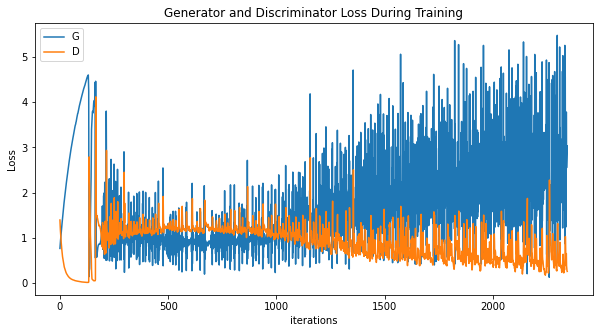

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show() 